1. The PA of Sersic won't agree with PA of non-par measurement
2. The Sersic center will be far from true center
2. M20 will be super large -> easy to rule out things

## Directly measure structural params on image

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [16]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet
from scarlet.display import AsinhMapping
from scarlet.source import StarletSource

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF
import unagi

import sep

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [328]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [658]:
lsbg_cat = Table.read('./Cutout/NSA/nsa_cutout_cat_1103.fits')
lsbg = lsbg_cat[int(np.where(lsbg_cat['viz-id'] == 28276)[0][0])]

In [659]:
len(lsbg_cat)

501

In [660]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [661]:
from kuaizi.utils import set_logger
logger = set_logger('_fitting_wavelet', f'{prefix}-{index}.log')

In [662]:
pixel_scale = kz.HSC_pixel_scale
tigress = True
show_figure = True
starlet_thresh = 0.5

In [663]:
print('  - Detect sources and make mask')
logger.info('  - Detect sources and make mask')
print('    Query GAIA stars...')
logger.info('    Query GAIA stars...')
gaia_cat, msk_star_ori = kz.utils.gaia_star_mask(  # Generate a mask for GAIA bright stars
    data.images.mean(axis=0),  # averaged image
    data.wcs,
    pixel_scale=pixel_scale,
    gaia_bright=19.5,
    mask_a=694.7,
    mask_b=3.8,
    factor_b=1.0,  # 0.7,
    factor_f=1.4,  # 1.0,
    tigress=tigress,
    logger=logger)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    3 stars from Gaia are masked!


    Detected 158 objects


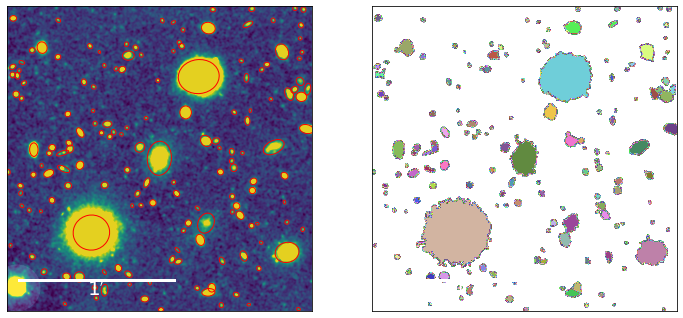

In [664]:
# This vanilla detection with very low sigma finds out where is the central object and its footprint
# if cutout is lareger than 200 arcsec => large galaxy, less aggressive deblend
if max(data.images.shape) * pixel_scale > 200:
    first_dblend_cont = 0.07
else:
    first_dblend_cont = 0.01

obj_cat_ori, segmap_ori, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=4, # a.k.a., "sigma"
    mask=msk_star_ori,
    method='vanilla',
    convolve=True,
    conv_radius=2,
    match_gaia=False,
    show_fig=show_figure,
    visual_gaia=False,
    b=80,
    f=3,
    pixel_scale=pixel_scale,
    minarea=20,
    deblend_nthresh=48,
    deblend_cont=first_dblend_cont,  # 0.01, 0.05, 0.07, I changed it to 0.1
    sky_subtract=True,
    logger=logger)

# segmap_ori[msk_star_ori.astype(bool)] = -1

catalog_c = SkyCoord(obj_cat_ori['ra'], obj_cat_ori['dec'], unit='deg')
dist = lsbg_coord.separation(catalog_c)
cen_indx_ori = obj_cat_ori[np.argsort(dist)[0]]['index'] # ori = original, i.e., first SEP run
cen_obj = obj_cat_ori[cen_indx_ori]

# Better position for cen_obj, THIS IS PROBLEMATIC!!! 
x, y, _ = sep.winpos(data.images.mean(
    axis=0), cen_obj['x'], cen_obj['y'], 6)
ra, dec = data.wcs.wcs_pix2world(x, y, 0)
cen_obj['x'] = x
cen_obj['y'] = y
cen_obj['ra'] = ra
cen_obj['dec'] = dec
cen_obj_coord = SkyCoord(cen_obj['ra'], cen_obj['dec'], unit='deg')

In [665]:
if gaia_cat is not None:
    # Find stars within the wavelet box, and mask them.
    star_flag = [(item[0] > starlet_extent[0]) & (item[0] < starlet_extent[1]) &
                 (item[1] > starlet_extent[2]) & (item[1] < starlet_extent[3])
                 for item in np.asarray(gaia_cat['x_pix', 'y_pix'])]
    
    # "star_cat" is a catalog for GAIA stars which fall in the Starlet box
    star_cat = gaia_cat[star_flag]
    
    # Parameters below really matter
    _, msk_star = kz.utils.gaia_star_mask(  # Generate GAIA mask only for stars outside of the Starlet box
        data.images.mean(axis=0),
        data.wcs,
        gaia_stars=gaia_cat[~np.array(star_flag)],
        pixel_scale=pixel_scale,
        gaia_bright=19.5,
        mask_a=694.7,
        mask_b=3.8,
        factor_b=0.8,
        factor_f=0.6,
        tigress=True,
        logger=None)
else:
    star_cat = []
    msk_star = np.copy(msk_star_ori)

    3 stars from Gaia are masked!


    Detected 168 objects


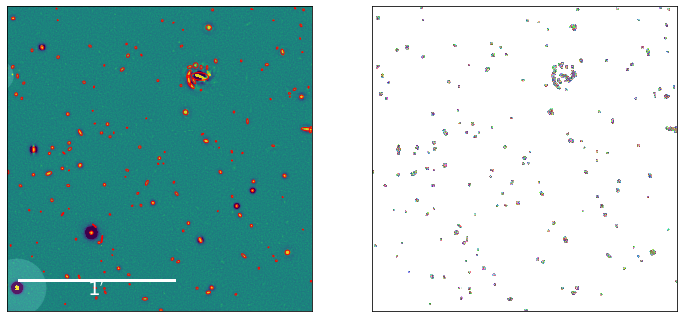

In [666]:
# This step masks out high frequency sources by doing wavelet transformation
obj_cat, segmap_highfreq, bg_rms = kz.detection.makeCatalog([data],
                                                            mask=msk_star,
                                                            lvl=2.,  # 2.5
                                                            method='wavelet',
                                                            high_freq_lvl=2,  # 3
                                                            wavelet_lvl=4,
                                                            match_gaia=False,
                                                            show_fig=show_figure,
                                                            visual_gaia=False,
                                                            b=24,
                                                            f=3,
                                                            pixel_scale=pixel_scale,
                                                            minarea=3,
                                                            deblend_nthresh=30,
                                                            deblend_cont=0.03,
                                                            sky_subtract=True,
                                                            logger=None)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
cen_indx_highfreq = obj_cat[np.argsort(dist)[0]]['index']

### Don't mask out objects that fall in the segmap of the central object and the Starlet box
segmap = segmap_highfreq.copy()
# overlap_flag is for objects which fall in the footprint 
# of central galaxy in the fist SEP detection
overlap_flag = [(segmap_ori == (cen_indx_ori + 1))[item]
                for item in list(zip(obj_cat['y'].astype(int), obj_cat['x'].astype(int)))]
overlap_flag = np.array(overlap_flag)

# # `box_flag` is for objects which fall in the initial Starlet box
# box_flag = np.unique(
#     segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]) - 1
# if len(box_flag) > 0:
#     box_flag = np.delete(np.sort(box_flag), 0)
#     overlap_flag[box_flag] = True
# if len(overlap_flag) > 0:
#     obj_cat_cpct = obj_cat[overlap_flag] # obj_cat_cpct is the catalog for compact sources

# Remove the source from `obj_cat_cpct` if it is the central galaxy
# if dist[cen_indx_highfreq] < 1 * u.arcsec:
#     obj_cat_cpct.remove_rows(
#         np.where(obj_cat_cpct['index'] == cen_indx_highfreq)[0])

overlap_flag |= (dist < 1 * u.arcsec)

for ind in np.where(overlap_flag)[0]:
    segmap[segmap == ind + 1] = 0

smooth_radius = 3
gaussian_threshold = 0.01
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(
    float), Gaussian2DKernel(smooth_radius))
# This `seg_mask` only masks compact sources
seg_mask = (mask_conv >= gaussian_threshold)

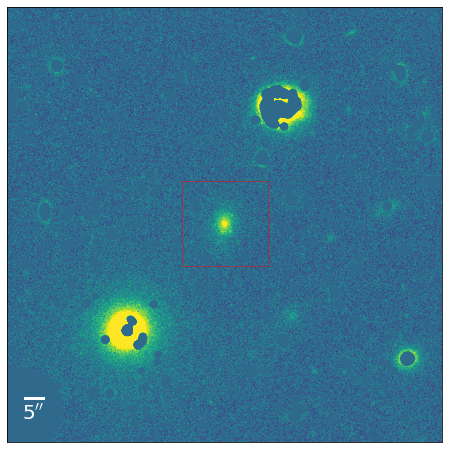

In [667]:
# Combine all masks (stars, compact sources, large sources) and display
fig = display_single(data.images[2] * (~(seg_mask + msk_star.astype(bool))))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
ax = plt.gca()
ax.add_patch(rect)

In [668]:
# We roughly guess the box size of the Starlet source
model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(data.channels))
model_frame = scarlet.Frame(
    data.images.shape,
    wcs=data.wcs,
    psf=model_psf,
    channels=list(data.channels))
observation = scarlet.Observation(
    data.images,
    wcs=data.wcs,
    psf=data.psfs,
    weights=data.weights,
    channels=list(data.channels))
observation = observation.match(model_frame)

cen_obj = obj_cat_ori[cen_indx_ori]
starlet_source = scarlet.StarletSource(model_frame,
                                       (cen_obj['ra'], cen_obj['dec']),
                                       observation,
                                       thresh=0.01,
                                       min_grad=-0.01,  # the initial guess of box size is as large as possible
                                       starlet_thresh=5e-3)

# If the initial guess of the box is way too large (but not bright galaxy), set min_grad = 0.1.
# The box is way too large
if starlet_source.bbox.shape[1] > 0.9 * data.images[0].shape[0] and (bright):
     # The box is way too large
    min_grad = 0.03
    smaller_box = True
elif starlet_source.bbox.shape[1] > 0.9 * data.images[0].shape[0] and (~bright):
    # not bright but large box: something must be wrong! min_grad should be larger
    min_grad = 0.05
    smaller_box = True
elif starlet_source.bbox.shape[1] > 0.6 * data.images[0].shape[0] and (bright):
    # If box is large and gal is bright
    min_grad = 0.02
    smaller_box = True
elif starlet_source.bbox.shape[1] > 0.6 * data.images[0].shape[0] and (~bright):
    # If box is large and gal is not bright
    min_grad = 0.02
    smaller_box = True
else:
    smaller_box = False
    
if smaller_box:
    starlet_source = scarlet.StarletSource(model_frame,
                                           (cen_obj['ra'], cen_obj['dec']),
                                           observation,
                                           thresh=0.01,
                                           min_grad=min_grad,
                                           starlet_thresh=5e-3)

starlet_extent = kz.display.get_extent(starlet_source.bbox)  # [x1, x2, y1, y2]

# extra padding, to enlarge the box
starlet_extent[0] -= 10
starlet_extent[2] -= 10
starlet_extent[1] += 10
starlet_extent[3] += 10

    Detected 55 objects


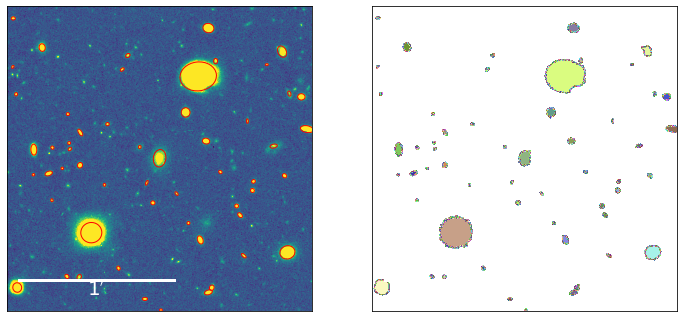

In [669]:
# This step masks out bright and large contamination, which is not well-masked in previous step
obj_cat, segmap_big, bg_rms = kz.detection.makeCatalog(
    [data],
    lvl=4.5,  # relative agressive threshold
    method='vanilla',
    match_gaia=False,
    show_fig=True,
    visual_gaia=False,
    b=32,
    f=3,
    pixel_scale=pixel_scale,
    minarea=20,   # only want large things
    deblend_nthresh=36,
    deblend_cont=0.01,
    sky_subtract=True,
    logger=None)

catalog_c = SkyCoord(obj_cat['ra'], obj_cat['dec'], unit='deg')
dist = cen_obj_coord.separation(catalog_c)
cen_indx_big = obj_cat_ori[np.argsort(dist)[0]]['index']

# mask out big objects that are NOT identified in the high_freq step
segmap = segmap_big.copy()
# segbox = segmap[starlet_extent[2]:starlet_extent[3], starlet_extent[0]:starlet_extent[1]]
# box_flag = np.unique(segbox) - 1
# if len(box_flag) > 0:
#     box_flag = np.delete(np.sort(box_flag), 0)
#     for ind in box_flag:
#         if np.sum(segbox == ind + 1) / np.sum(segmap == ind + 1) > 0.5: segmap[segmap == ind + 1] = 0
#     box_flag = np.delete(box_flag, np.where(box_flag == cen_indx_big)[
#         0])  # dont include the central galaxy
#     obj_cat_big = obj_cat[box_flag]
# else:
#     obj_cat_big = obj_cat
segmap[segmap == cen_indx_big + 1] = 0
# `obj_cat_big` is catalog of the big/high SNR objects in the image
    
smooth_radius = 7
gaussian_threshold = 0.01
mask_conv = np.copy(segmap)
mask_conv[mask_conv > 0] = 1
mask_conv = convolve(mask_conv.astype(float), Gaussian2DKernel(smooth_radius))
# This `seg_mask_large` masks large bright sources
seg_mask_large = (mask_conv >= gaussian_threshold)

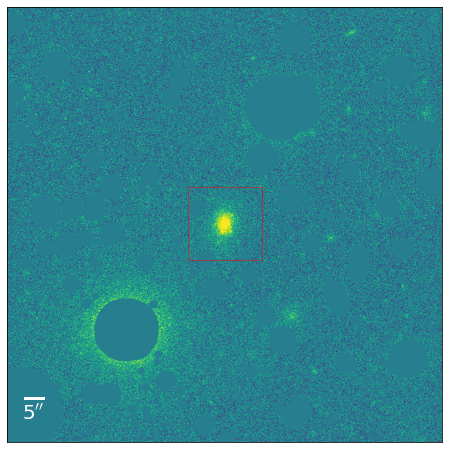

In [670]:
# Combine all masks (stars, compact sources, large sources) and display
fig = display_single(data.images[2] * (~(seg_mask_large + seg_mask + msk_star.astype(bool))))
from matplotlib.patches import Rectangle
box_kwargs = {"facecolor": "none", "edgecolor": "r", "lw": 0.5}
rect = Rectangle(
    (starlet_extent[0], starlet_extent[2]),
    starlet_extent[1] - starlet_extent[0],
    starlet_extent[3] - starlet_extent[2],
    **box_kwargs
)
ax = plt.gca()
ax.add_patch(rect)

In [671]:
mask = (seg_mask_large + seg_mask + msk_star.astype(bool))

In [672]:
components = [starlet_source]

In [673]:
min_cutout_size = max([comp.bbox.shape[1] for comp in components])

lower_left = np.min([np.array(comp.bbox.origin) for comp in components], axis=0)
upper_right = np.max([np.array(comp.bbox.origin) + np.array(comp.bbox.shape) for comp in components], axis=0)
bbox = scarlet.Box(upper_right - lower_left, origin=lower_left)
bbox.center = np.array(bbox.origin) + np.array(bbox.shape) // 2
bbox.shape = tuple(int(i * 1.5) for i in bbox.shape)
bbox.origin = tuple(bbox.center[i] - bbox.shape[i] // 2 for i in range(3))

In [674]:
images = data.images
weights = data.weights
psfs = data.psfs.get_model()


images = images[:, bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
            bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
images = np.ascontiguousarray(images)
mask = mask[bbox.origin[1]:bbox.origin[1] + bbox.shape[1],
            bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
mask = np.ascontiguousarray(mask)
weights = weights[:, bbox.origin[1]:bbox.origin[1] +
                  bbox.shape[1], bbox.origin[2]:bbox.origin[2] + bbox.shape[2]]
weights = np.ascontiguousarray(weights)

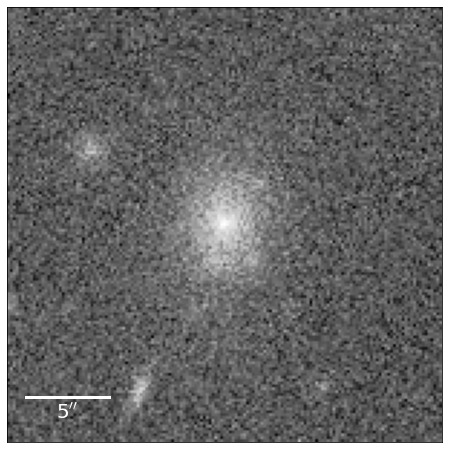

In [675]:
display_single(images[2], scale='linear', cmap='Greys_r');

In [676]:
# We take the model and weight map in g-band. Such that we can use the SED to get
# surface brightness in other bands.
# A sky background is estimated on the original image,
# and we run `sep` to generate a 1-sigma segmentation map.
# Then we run `statmorph` using that segmap
sigma = 2

filt = 0
img = np.average(images, weights=weights.sum(axis=(1, 2)), axis=0)
#img = images[filt]#models[filt]
bkg = sep.Background(img, bh=12, bw=12, mask=mask) # 
_, segmap = sep.extract(img, sigma, err=bkg.globalrms, minarea=1,
                        deblend_cont=1,
                        mask=None, segmentation_map=True)

# mask = np.copy(segmap)

# cen_ind = [segmap[int(comp.center[0] - comp.bbox.origin[1]), 
#                   int(comp.center[1] - comp.bbox.origin[2])] for comp in components]
cen_ind = [segmap[int(bbox.center[1] - bbox.origin[1]), 
                  int(bbox.center[2] - bbox.origin[2])] for comp in components]
segmap[~np.add.reduce([segmap == ind for ind in cen_ind]).astype(bool)] = 0

segmap = (segmap > 0)
segmap = convolve(segmap, Gaussian2DKernel(4)) > 0.01

# mask[~np.add.reduce([mask != ind for ind in cen_ind]).astype(bool)] = 0
# mask = (mask > 0)
# mask = convolve(mask, Gaussian2DKernel(1)) > 0.002
# bkg = sep.Background(img, bh=15, bw=15, mask=None) # 
#img -= bkg.globalback
# img -= bkg.back()

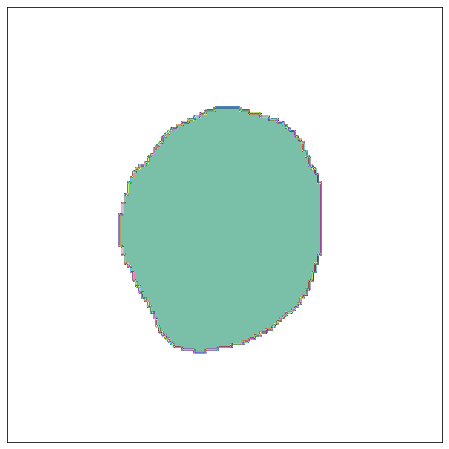

In [677]:
display_single(segmap.astype(float), cmap=SEG_CMAP, scale='linear');

In [678]:
# img[~segmap] = np.nan

In [679]:
# segmap = np.ones_like(img) # no segmap

In [680]:
source_morphs = statmorph.source_morphology(
    img, segmap, weightmap=np.sqrt(weights[filt]),
    n_sigma_outlier=10, min_cutout_size=min_cutout_size, 
    cutout_extent=2.,
    skybox_size=24,
    #petro_extent_cas=1,
    #petro_fraction_gini=0.1,
    mask=mask, 
    psf=psfs[filt])
morph = source_morphs[0]

In [681]:
print(morph.asymmetry, morph.outer_asymmetry)

-0.025734151569493036 -0.034779413478721204


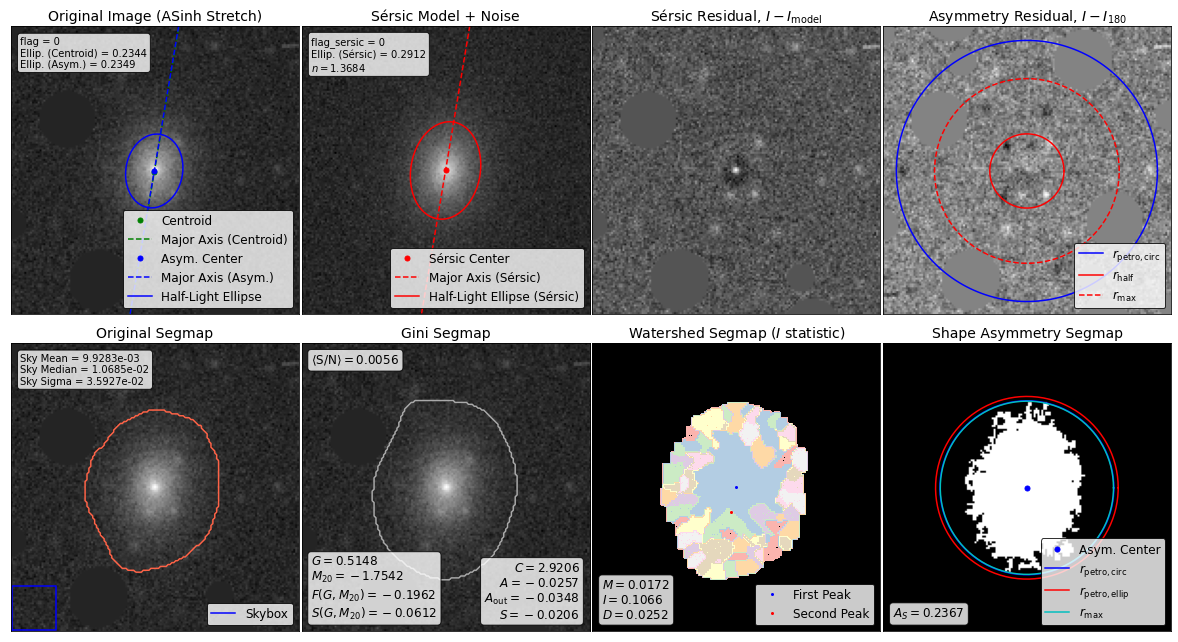

In [682]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph, asinh_a=0.5)

In [478]:
with open(f"./Model/NSA/nsa-{lsbg['viz-id']}-trained-model-vanilla.df", "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()

In [479]:
from kuaizi.measure import makeMeasurement

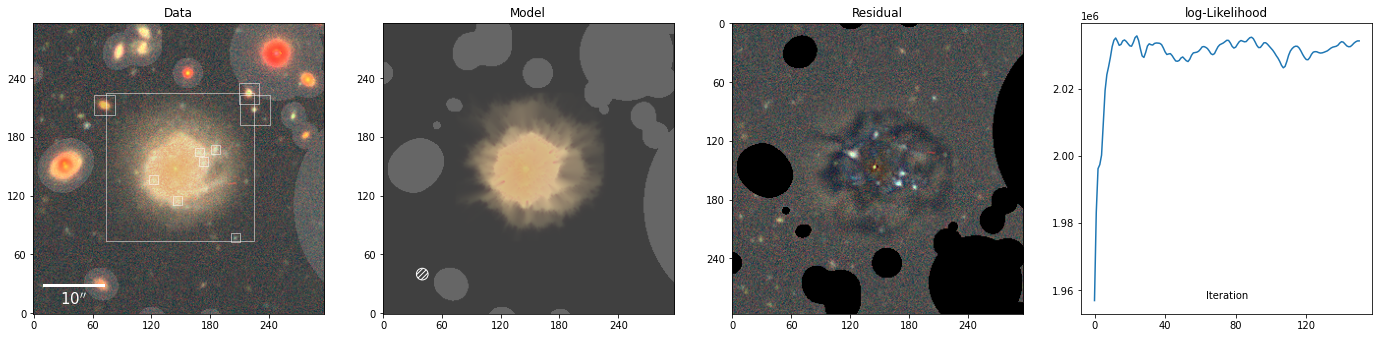

In [480]:
fig = kz.display.display_scarlet_results_tigress(
            blend,
            mask,
            show_ind=info['sed_ind'],
            zoomin_size=50,
            minimum=-0.3,
            stretch=1,
            Q=1,
            channels=blend.observations[0].channels,
            show_loss=True,
            show_mask=False,
            show_mark=False,
            scale_bar=True)

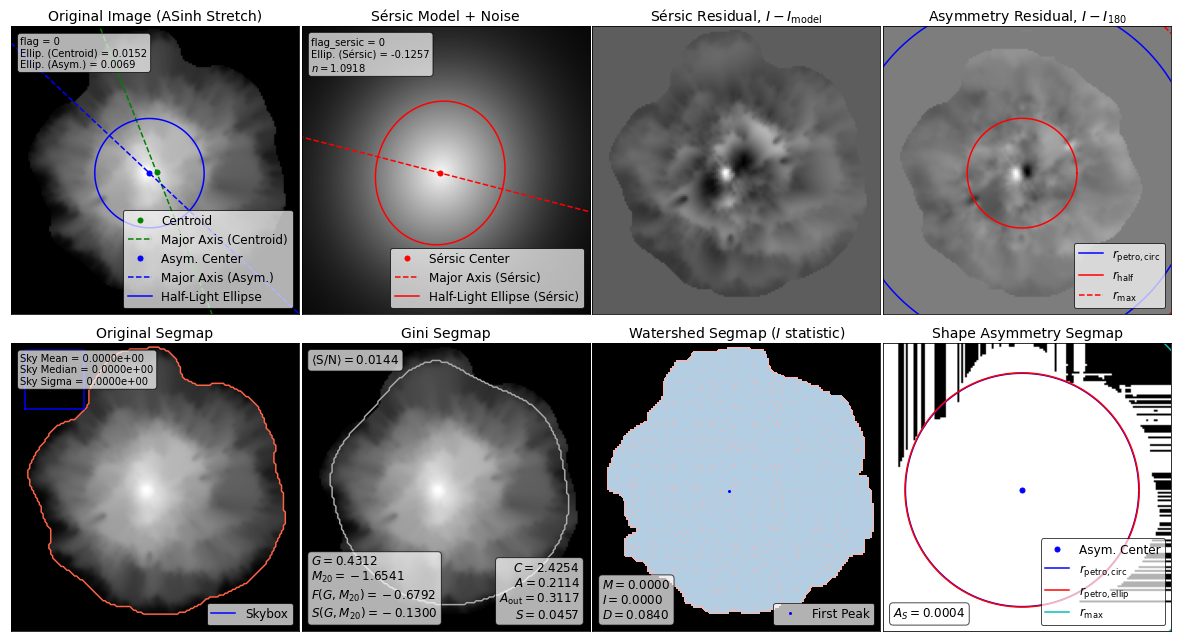

In [482]:
measurement, morph = makeMeasurement(blend.sources[0:1], #list(np.array(blend.sources)[info['sed_ind']]),
                                                blend.observations[0], 
                                                aggr_mask=mask.astype(bool), 
                                                makesegmap=True, #sigma=1,
                                                zeropoint=27.0, out_prefix=None, 
                                                show_fig=True, framealpha=0.7)